## CSP 304: Machine Learning Lab (Spring 2023)
# Homework 1

Name: Samarth Bhatt <br>
College ID: 2020KUCP1068 <br>
Lab Batch: A3
<br>
<br>
<br>
<br>

# Topic A

This part of homework illustrates the use of resampling methods for model selection (complexity
control), and for comparing prediction accuracy of a learning method.

## A1: KNN Implementation

<b>Syntax:</b> K_nearest_classifier(dataset, class_column, new_data, k)
<br><br>
<b>Parameters:</b>
<li>dataset: 2D numpy array of already classified data</li>
<li>class_column: 1D numpy array of classes for each row in dataset</li>
<li>new_data: 1D numpy array to be classified</li>
<li>k: number of nearest neighbour in KNN</li>
<br>
<b>Returns:</b> class in which new_data belongs

In [1]:
import math
import pandas as pd
import numpy as np

def k_nearest_neighbors(dataset, class_column, new_data, k) :
    class_count = {}
    k_neighbors = [{'Class': math.nan, 'Distance': math.inf} for i in range(0, k)]
    
    # Initializing all class counts to 0
    for class_label in np.unique(class_column) :
        class_count[class_label] = 0
    
    # Calculating distance of new_data from each data point and storing k closest points in k_neighbors
    for row_index in range(0, dataset.shape[0]) :
        row = dataset[row_index, :]
        distance = 0
        
        # Calculating Euclidean distance between two data points
        for column in range(0, dataset.shape[1]) :
            distance = distance + (row[column] - new_data[column])**2
        
        distance = math.sqrt(distance)
        biggest = 0
        index_biggest = -1
        
        # Checking if the current distance is smaller than the biggest distance in k_neighbors
        for i in range(0, len(k_neighbors)) :
            if k_neighbors[i]['Distance'] > biggest and k_neighbors[i]['Distance'] > distance :
                biggest = k_neighbors[i]['Distance']
                index_biggest = i
               
        if (index_biggest != -1) :
            class_label = class_column[row_index]
            k_neighbors[index_biggest]['Distance'] = distance
            k_neighbors[index_biggest]['Class'] = class_label
            k_neighbors.sort(key=lambda d: d['Distance'])
    
    highest_count = 0
    predicted_class = None
    
    # Setting class count to the number of points in k_neighbors that belong to that class
    # The class with the highest count is predicted class
    for neighbor in k_neighbors :
        class_label = neighbor['Class']
        class_count[class_label] = class_count[class_label] + 1
        if (highest_count < class_count[class_label]) :
            highest_count = class_count[class_label]
            predicted_class = class_label
      
    return predicted_class

## Data
Haberman’s Survival Data Set, taken from UCI Machine Learning Repository at:
http://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival,
Each of the 306 patient records has a class label (alive/dead) indicating whether the patient survived
5 years or longer after surgery, or died within 5 years. Each patient record has 3 inputs: Age
of patient; Year of operation, and Number of positive auxiliary nodes detected. The goal is to estimate the decision boundary between the two classes, using x1 ∼ Age of patient and x2 ∼ Number
of positive auxiliary nodes, to predict patient’s survival. As a part of preprocessing, pre-scale each
input to a [0, 1] range, using min and max values of that input.

In [2]:
csv_data = pd.read_csv('./haberman.data')
np_data = np.array(csv_data)
df = pd.DataFrame(np_data, columns=['Age', 'Year', 'Axillary Nodes', 'Survival Status'])

# Displaying first 5 rows of the dataframe
display(df.head())

# Printing the distribution of the target class
print('Class distribution')
df['Survival Status'].value_counts()

,Age,Year,Axillary Nodes,Survival Status
0,30,62,3,1
1,30,65,0,1
2,31,59,2,1
3,31,65,4,1
4,33,58,10,1


Class distribution


1    224
2     81
Name: Survival Status, dtype: int64

## A2: Leave One Out (LOO) cross-validation

<b>Syntax:</b> loo_cross_validation(X, y, k)
<br><br>
<b>Parameters:</b>
<li>X: 2D numpy array of already classified data</li>
<li>y: 1D numpy array of classes for each row in dataset</li>
<li>k: number of nearest neighbours in KNN</li>
<br>
<b>Returns:</b> Mean Squared Error (MSE) after validation

In [3]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

def loo_cross_validation(X, y, k) :
    predictions = []
    actual_classes = []
    loo = LeaveOneOut()
    
    # Iterating over each row of the dataset as a test point and rest as training data
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        train_data_x = X[train_index, :]
        train_data_y = y[train_index]
        test_data_x = X[test_index[0]]
        actual_class = y[test_index[0]]
        
        # Predicting the class of the test point using k-nearest neighbors
        predicted_class = k_nearest_neighbors(train_data_x, train_data_y, test_data_x, k) 
        predictions.append(predicted_class)
        actual_classes.append(actual_class)
        
    # Calculating mean squared error of the predictions
    mse = mean_squared_error(actual_classes, predictions)
    
    return mse

### LOO cross validation for K in range (1, 100)

In [4]:
from sklearn.preprocessing import minmax_scale

scaled_data = minmax_scale(df[['Age', 'Axillary Nodes']])
survival_status = df['Survival Status'].to_numpy()

errors = {}

# Iterating over different values of k
for k in range(1, 100, 2):
    # Performing leave-one-out cross-validation to calculate mean squared error
    error = loo_cross_validation(scaled_data, survival_status, k)
    errors[k] = error

### Variation of MSE with K

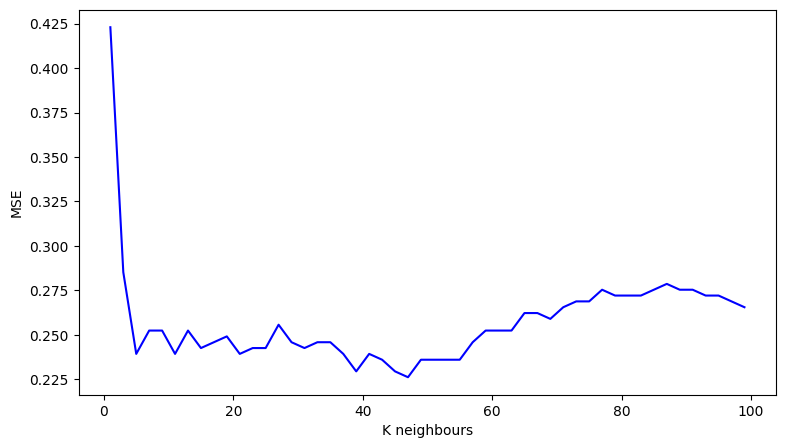

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot([x for x in errors.keys()], [y for y in errors.values()], 'b')
plt.xlabel('K neighbours')
plt.ylabel('MSE')
plt.show()

### Choosing optimal K with minimum MSE

In [6]:
best_k = 1

for k in errors.keys() :
    if errors[k] < errors[best_k] :
        best_k = k

print('Optimal K:', best_k)
print('Least MSE:', errors[best_k])

Optimal K: 47
Least MSE: 0.2262295081967213


### Decision boundary

Decision boundary between the two classes, using x1 ∼ Age of patient and x2 ∼ Number
of positive auxiliary nodes, to predict patient’s survival. As a part of preprocessing, pre-scale each
input to a [0, 1] range, using min and max values of that input.

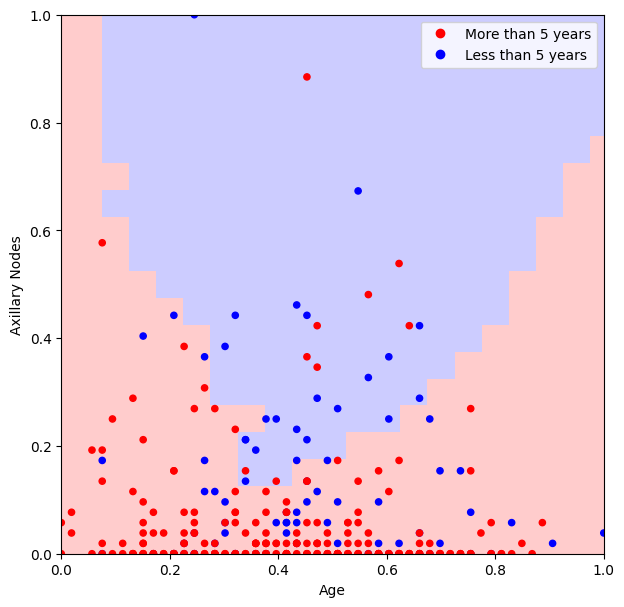

In [7]:
from matplotlib.colors import ListedColormap

# Defining color maps for plotting
cmap_light = ListedColormap(['#FFCCCC', '#CCCCFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

# lower step rate means highly defined (smooth) decision boundary but more processing time
step = 0.05    # Defining step size for meshgrid

# Scaling features and getting target variable
X_train = minmax_scale(df[['Age', 'Axillary Nodes']])
y_train = df['Survival Status'].to_numpy()

# dividing plot in a mesh and calculating in which class each mesh belongs and color it accordingly
# this mesh gives us and idea of decision boundary
xx, yy = np.meshgrid(np.arange(0, 1 + step, step), np.arange(0, 1 + step, step))
age = xx.ravel()
axillary_nodes = yy.ravel()

# Predicting target variable for each point in meshgrid
Z = []
for index in range(0, len(age)) :
    new_data = [age[index], axillary_nodes[index]]
    predicted_class = k_nearest_neighbors(X_train, y_train, new_data, best_k) 
    Z.append(predicted_class)
    
Z = np.array(Z).reshape(xx.shape)

# Plotting decision boundary
plt.figure(figsize=(7,7))

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('Age')
plt.ylabel('Axillary Nodes')

# Plotting data points
scatter = plt.scatter(scaled_data[:,0], scaled_data[:,1], c=df['Survival Status'], cmap=cmap_bold, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=['More than 5 years', 'Less than 5 years'])
plt.show()

## A3: 5-fold cross-validation for estimating test error

1. Use 5-fold cross-validation for estimating test error, by taking out every 5-th sample as a test set. This will result in 5 different partitions (folds) of the data into
training + test sets

2. Within each fold, estimate an optimal value of k via LOO cross-validation.


In [8]:
from sklearn.model_selection import KFold

# Scaling the features
scaled_data = minmax_scale(df[['Age', 'Axillary Nodes']])
target = df['Survival Status'].to_numpy()

# Splitting data into 5 folds
kf = KFold(n_splits=5)

# Creating a dataframe to hold error values for each fold
error_df = pd.DataFrame(columns=['K', 'LOO Validation Error', 'Estimated Test Error'])

# Calculating optimal k by calculating LOO validation error for each fold and estimating test error
for i, (train_index, test_index) in enumerate(kf.split(scaled_data)):
    X_train = scaled_data[train_index, :]
    y_train = target[train_index]
    X_test = scaled_data[test_index, :]
    y_test = target[test_index]

    # Calculating the LOO validation error for different values of k
    errors = {}
    for k in range(1, 100, 2):
        error = loo_cross_validation(X_train, y_train, k)
        errors[k] = error

    # Selecting the value of k with the lowest LOO validation error
    best_k = min(errors, key=errors.get)

    # Making predictions on test data using the best value of k
    predictions = []
    actual_classes = []
    for i in range(0, len(X_test)):
        test_case = X_test[i]
        actual_class = y_test[i]
        predicted_class = k_nearest_neighbors(X_train, y_train, test_case, best_k)
        predictions.append(predicted_class)
        actual_classes.append(actual_class)

    # Calculating the estimated test error
    test_error = mean_squared_error(actual_classes, predictions)

    # Adding the results to the dataframe
    new_row = pd.DataFrame([{'K': best_k, 'LOO Validation Error': errors[best_k], 'Estimated Test Error': test_error}])
    error_df = pd.concat([error_df, new_row], axis=0)

# Resetting the index of the dataframe
error_df.reset_index(inplace=True, drop=True)
error_df

,K,LOO Validation Error,Estimated Test Error
0,39,0.245902,0.147541
1,33,0.204918,0.295082
2,5,0.229508,0.278689
3,21,0.241803,0.229508
4,11,0.217213,0.262295


### True Test Error

In [9]:
# calculating the mean of the "Estimated Test Error" column in the error_df dataframe
true_test_error = error_df['Estimated Test Error'].mean()

# printing the true test error
print('True Test Error: ', true_test_error)

True Test Error:  0.24262295081967214


### Mean LOO Validation Error

In [10]:
loo_validation_error = error_df['LOO Validation Error'].mean()
print('Mean LOO Validation Error: ', loo_validation_error)

Mean LOO Validation Error:  0.2278688524590164


<br>
<br>
<br>
<br>

# Topic B
This part of homework illustrates the estimation of parametric models using maximum likelihood
estimation (MLE) methodology.

### Importing training data

In [11]:
import pandas as pd
import numpy as np

# reading in data from three text files and creating pandas dataframes
csv_data = pd.read_csv('./data/training_data1.txt', header=None)
np_data = np.array(csv_data)
df_train_1 = pd.DataFrame(np_data)

csv_data = pd.read_csv('./data/training_data2.txt', header=None)
np_data = np.array(csv_data)
df_train_2 = pd.DataFrame(np_data)

csv_data = pd.read_csv('./data/training_data3.txt', header=None)
np_data = np.array(csv_data)
df_train_3 = pd.DataFrame(np_data)

# creating a copy of the first dataframe and assigning it to df_train_example
df_train_example = df_train_1.copy()
df_train_example.head()

,0,1,2,3,4,5,6,7,8
0,3.0956,5.0049,2.3180,-6.39460,0.354200,8.1000,-0.31242,-9.01310,2.0
1,2.8768,3.7028,5.5192,1.87420,-0.013561,6.3650,2.52880,-4.58890,2.0
2,5.9957,5.1400,5.9457,-0.17749,-0.520860,8.4861,3.01480,-7.06350,2.0
3,6.9239,7.0724,4.8416,-0.41263,2.033700,5.8409,-0.45747,-3.88040,2.0
4,5.6573,9.7116,7.0658,2.02000,3.179800,9.0299,1.14750,-0.59077,2.0


### Importing test data

In [12]:
csv_data = pd.read_csv('./data/test_data1.txt', header=None)
np_data = np.array(csv_data)
df_test_1 = pd.DataFrame(np_data)

csv_data = pd.read_csv('./data/test_data2.txt', header=None)
np_data = np.array(csv_data)
df_test_2 = pd.DataFrame(np_data)

csv_data = pd.read_csv('./data/test_data3.txt', header=None)
np_data = np.array(csv_data)
df_test_3 = pd.DataFrame(np_data)

df_test_example = df_test_1.copy()
df_test_example.head()

,0,1,2,3,4,5,6,7,8
0,2.1533,2.7852,-0.81808,-5.73960,-1.82640,-0.74412,-9.90850,-8.5041,1.0
1,4.4908,6.8576,7.07680,0.83217,1.19010,8.24610,0.19494,-4.7383,2.0
2,4.3667,4.9828,4.97740,-1.30040,-0.61913,6.65200,-2.31960,-6.1060,2.0
3,3.9579,4.3911,3.81880,3.87610,-0.89189,5.51460,-1.69780,-8.9219,2.0
4,5.3985,4.9170,3.75910,-0.81478,2.88860,5.17850,-2.87480,-11.2120,2.0


### Grouping data based on class

In [13]:
# Displaying the first few rows of each group in the example data set
example_groups = df_train_example.groupby(df_train_example.iloc[:, -1])

for name, group in example_groups:
    # Dropping the last column (class labels) from the group DataFrame
    group = group.drop(group.columns[[-1]], axis=1)
    # Displaying the first few rows of the group DataFrame
    display(group.head()) 

,0,1,2,3,4,5,6,7
5,1.41710,-0.35240,3.72760,-3.47220,-8.1917,2.60460,-5.7488,-15.4950
6,-0.95051,0.40644,2.80590,-4.45300,-2.0135,3.05370,-6.3201,-9.0701
11,-0.32868,4.44300,0.20531,-1.61620,-1.2544,2.92140,-6.0426,-2.7748
12,1.89610,2.54750,7.45160,-0.97849,-2.7451,1.95810,-5.5524,-9.3531
27,1.60650,0.65671,4.12560,0.35526,-3.3605,0.92004,-2.4176,-9.9895


,0,1,2,3,4,5,6,7
0,3.0956,5.0049,2.3180,-6.39460,0.354200,8.1000,-0.31242,-9.01310
1,2.8768,3.7028,5.5192,1.87420,-0.013561,6.3650,2.52880,-4.58890
2,5.9957,5.1400,5.9457,-0.17749,-0.520860,8.4861,3.01480,-7.06350
3,6.9239,7.0724,4.8416,-0.41263,2.033700,5.8409,-0.45747,-3.88040
4,5.6573,9.7116,7.0658,2.02000,3.179800,9.0299,1.14750,-0.59077


### Class Probability - P( C<sub>i</sub> )

<b>Syntax:</b> get_probability_class(groups)
<br><br>
<b>Parameters:</b>
<li>groups: groupby object that contains data grouped by class</li>
<br>
<b>Returns:</b> a dictionary with probability occurance of each class

In [14]:
# Function to calculate the probability of each class in a given dataset
def calculate_class_probability(groups) :
    class_probability = {}
    total_rows = 0
    
    # Iterating over each class label in the dataset
    for label in groups.groups.keys() :
        # Geting the group corresponding to the current class label
        group = groups.get_group(label)
        # Storing the number of rows in the group
        class_probability[label] = group.shape[0]
        # Adding the number of rows to the total count of rows in the dataset
        total_rows = total_rows + group.shape[0]
        
    # Calculating the probability of each class label as the number of rows in the group divided by the total number of rows
    for label, count in class_probability.items() :
        class_probability[label] = count / total_rows
        
    return class_probability

# Using Calculate_class_probability function on the example dataset
example_groups = df_train_example.groupby(df_train_example.iloc[:, -1])
class_probability = calculate_class_probability(example_groups)
print(class_probability)

{1.0: 0.3, 2.0: 0.7}


### Class Mean - &mu;

<b>Syntax:</b> get_mean(groups)
<br><br>
<b>Parameters:</b>
<li>groups: groupby object that contains data grouped by class</li>
<br>
<b>Returns:</b> dictionary with group name as key and mean feature values as value

In [15]:
def get_mean(groups) :
    mean_groups = groups.mean()
    mean = {key: mean_groups.loc[key].to_numpy()[0:8] for key in groups.groups.keys()}
    return mean

get_mean(example_groups)

{1.0: array([ 0.43061855,  2.02352   ,  3.17582833, -2.4272419 , -2.52344133,
         3.23778627, -5.52077   , -6.69214667]),
 2.0: array([ 4.584063  ,  6.49331857,  6.42650643,  1.6890596 ,  2.29434109,
         8.36257286, -0.1657858 , -1.80476893])}

## B1

The priors P(C<sub>1</sub>) and P(C<sub>2</sub>) should be estimated from the training data.
Three pairs of training data and test data
are given. The parameters μ<sub>1</sub>, μ<sub>2</sub>, S<sub>1</sub> and S<sub>2</sub>,
the mean and covariance for class 1 and class 2, are learned in the following
three models for each training data and test data pair.

### Model 1
Assume independent S<sub>1</sub> and S<sub>2</sub>.

<b>Syntax:</b> model_1(groups, mean, pc, column_count)
<br><br>
<b>Parameters:</b>
<li>groups: groupby object that contains data grouped by class</li>
<li>mean: a dictionary with an array of mean column values for each class</li>
<li>pc:  a dictionary with probability occurance of each class</li>
<li>column_count: number of columns in each group</li>
<br>
<b>Returns:</b> a dictionary of covariance matrix (2D numpy array) for each class

In [16]:
def model_1(groups, mean, pc, column_count) :
    s = {key: np.zeros((column_count, column_count)) for key in groups.groups.keys()}
    
    for key in groups.groups.keys() :
        df = groups.get_group(key)
        s[key] = df.cov().to_numpy()
                
    return s

### Discriminant 1

<b>Syntax:</b> discriminant_1(i, x, s, mean, pc)
<br><br>
<b>Parameters:</b>
<li>i: name of class</li>
<li>x: 1D numpy array data to be classified</li>
<li>s: a dictionary of covariance matrix (2D numpy array) for each class</li>
<li>mean: a dictionary with a list of mean column values for each class</li>
<li>pc: a dictionary with probability occurance of each class</li>
<br>
<b>Returns:</b> discriminant value g (x belongs to a class if the value of g for that class is higher)

In [17]:
def discriminant_1(i, x, s, mean, pc) :
    det_s = np.linalg.det(s[i])
    matrix_multiplication = np.matmul(np.matmul((x - mean[i]).T, np.linalg.inv(s[i])), (x - mean[i]))
    
    g = -1/2 * math.log(det_s) - 1/2 * matrix_multiplication + math.log(pc[i])
    
    return g

### Model 2
Assume S<sub>1</sub> = S<sub>2</sub>. In other words, shared S between two classes.

<b>Syntax:</b> model_2(groups, mean, pc, column_count)
<br><br>
<b>Parameters:</b>
<li>groups: groupby object that contains data grouped by class</li>
<li>mean: a dictionary with a list of mean column values for each class</li>
<li>pc:  a dictionary with probability occurance of each class</li>
<li>column_count: number of columns in each group</li>
<br>
<b>Returns:</b> a common covariance matrix (2D numpy array)

In [18]:
def model_2(groups, mean, pc, column_count) :
    s = {key: np.zeros((column_count, column_count)) for key in groups.groups.keys()}
    
    for key in groups.groups.keys() :
        df = groups.get_group(key)
        s[key] = df.cov().to_numpy()
    
    common_s = np.zeros((column_count, column_count))
    
    for class_name, covariance_matrix in s.items() :
        common_s = common_s + (covariance_matrix * pc[class_name])
          
    return common_s

### Discriminant 2

<b>Syntax:</b> discriminant_2(i, x, common_s, mean, pc)
<br><br>
<b>Parameters:</b>
<li>i: name of class</li>
<li>x: data to be classified</li>
<li>s: a common covariance matrix (2D numpy array) for all classes</li>
<li>mean: a dictionary with a list of mean column values for each class</li>
<li>pc: a dictionary with probability occurance of each class</li>
<br>
<b>Returns:</b> discriminant value g (x belongs to a class if the value of g for that class is higher)

In [19]:
def discriminant_2(i, x, common_s, mean, pc) :
    det_s = np.linalg.det(common_s)
    matrix_multiplication = np.matmul(np.matmul((x - mean[i]).T, np.linalg.inv(common_s)), (x - mean[i]))
    
    g = - 1/2 * math.log(det_s) -1/2 * matrix_multiplication + math.log(pc[i])
    
    return g

### Model 3
Assume S<sub>1</sub> and S<sub>2</sub> are diagonal (the Naive Bayes scenario)

<b>Syntax:</b> model_3(groups, mean, pc, column_count)
<br><br>
<b>Parameters:</b>
<li>groups: groupby object that contains data grouped by class</li>
<li>mean: a dictionary with a list of mean column values for each class</li>
<li>pc:  a dictionary with probability occurance of each class</li>
<li>column_count: number of columns in each group</li>
<br>
<b>Returns:</b> a common covariance matrix (2D numpy array)

In [20]:
def model_3(groups, mean, pc, column_count) :
    s = {key: np.zeros((column_count, column_count)) for key in groups.groups.keys()}
    
    for key in groups.groups.keys() :
        df = groups.get_group(key)
        np.fill_diagonal(s[key], df.var().to_numpy())
       
    common_s = np.zeros((column_count, column_count))
    
    for class_name, covariance_matrix in s.items() :
        common_s = common_s + (covariance_matrix * pc[class_name])
       
    return common_s

### Discriminant 3

<b>Syntax:</b> discriminant_3(i, x, common_s, mean, pc)
<br><br>
<b>Parameters:</b>
<li>i: name of class</li>
<li>x: data to be classified</li>
<li>s: a common covariance matrix (2D numpy array) for all classes</li>
<li>mean: a dictionary with a list of mean column values for each class</li>
<li>pc: a dictionary with probability occurance of each class</li>
<br>
<b>Returns:</b> discriminant value g (x belongs to a class if the value of g for that class is higher)

In [21]:
def discriminant_3(i, x, common_s, mean, pc) :
    matrix_multiplication = np.matmul(np.matmul((x - mean[i]).T, np.linalg.inv(common_s)), (x - mean[i]))
    
    g = -1/2 * matrix_multiplication + math.log(pc[i])
    
    return g

## B2

### MultiGaussian

<b>Syntax:</b> MultiGaussian(df_train, df_test, model_number)
<br><br>
<b>Parameters:</b>
<li>df_train: training dataframe object</li>
<li>df_test: testing dataframe object</li>
<li>model_number: gaussian model to be used</li>
<br>
<b>Returns:</b> accuracy of the model

In [22]:
from sklearn.metrics import accuracy_score

def MultiGaussian(df_train, df_test, model_number) :
    if (model_number == 1) :
        model = model_1
        discriminant = discriminant_1
        
    if (model_number == 2) :
        model = model_2
        discriminant = discriminant_2
        
    if (model_number == 3) :
        model = model_3
        discriminant = discriminant_3
    
    groups = df_train.iloc[:, :8].groupby(df_train.iloc[:, 8])
    
    mean = get_mean(groups)
    probability_class = calculate_class_probability(groups)
    
    s = model(groups, mean, probability_class, column_count=8)
    
    actual_class = df_test.iloc[:, 8].to_numpy()
    predicted_class = []

    for i in range(0, df_test.shape[0]) :
        row = df_test.iloc[i].to_numpy()[0:8]
        g_dict = {}
        max_value = -math.inf
        max_value_key = 0

        for key in groups.groups.keys() :
            g = discriminant(key, row, s, mean, probability_class)
            g_dict[key] = g

        for key, value in g_dict.items() :
            if value > max_value :
                max_value = value
                max_value_key = key

        predicted_class.append(max_value_key)
    accuracy = accuracy_score(actual_class, predicted_class)
    
    return accuracy

### Testing models with all dataset pair

In [23]:
for model_number in [1, 2, 3] :
    x = 0
    y = 0
    index = ['Test 1', 'Test 2', 'Test 3']
    columns = ['Train 1', 'Train 2', 'Train 3']
    df_stats = pd.DataFrame(columns=columns, index=index)
    
    for df_train in [df_train_1, df_train_2, df_train_3] :
        for df_test in [df_test_1, df_test_2, df_test_3] :
            df_stats.iat[x, y] = MultiGaussian(df_train, df_test, model_number)
            x = x + 1
        y = y + 1
        x = 0
    display(df_stats)

,Train 1,Train 2,Train 3
Test 1,0.8,0.63,0.7
Test 2,0.46,0.77,0.69
Test 3,0.51,0.74,0.88


,Train 1,Train 2,Train 3
Test 1,0.83,0.83,0.85
Test 2,0.42,0.44,0.45
Test 3,0.43,0.47,0.55


,Train 1,Train 2,Train 3
Test 1,0.85,0.87,0.82
Test 2,0.36,0.41,0.49
Test 3,0.35,0.41,0.5
